In [2]:
from attention import AttentionLayer

In [3]:
##Import the libraries
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
df =  pd.read_csv('Reviews.csv')

In [5]:
df[:5]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.info

<bound method DataFrame.info of             Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...        ...         ...             ...                              ...   
568449  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

        Helpfulness

In [7]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [9]:
df['Text'][0:2]

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
Name: Text, dtype: object

In [10]:
df['Summary'][0:2]

0    Good Quality Dog Food
1        Not as Advertised
Name: Summary, dtype: object

In [11]:
len(df)

568454

In [12]:
df.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates


In [13]:
len(df)   ###There were a lot of duplicate texts

393579

In [14]:
df.dropna(axis = 0 ,inplace = True)

In [15]:
df.reset_index(inplace  = True)

Drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [16]:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

We need to define two different functions for preprocessing the reviews and generating the summary since the preprocessing steps involved in text and summary differ slightly.

In [17]:
df['Text'][5]

'I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.'

We will perform the below preprocessing tasks for our data:

• Convert everything to lowercase
• Remove HTML tags
• Contraction mapping
• Remove (‘s)
• Remove any text inside the parenthesis ( )
• Eliminate punctuations and special characters
• Remove stopwords
• Remove short words

In [18]:

stop_words = set(stopwords.words('english'))

In [19]:
len(stop_words)

179

In [20]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()


In [21]:
cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t))

### Summary Cleaning
And now we’ll look at the first 10 rows of the reviews to an idea of the preprocessing steps for the summary column:

In [22]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString



In [23]:
#Call the above function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))



In [24]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary


In [25]:
df['cleaned_text'].isnull().sum()

0

In [26]:
df['cleaned_summary'].isnull().sum()

0

In [27]:
df['cleaned_summary']

0                      good quality dog food 
1                          not as advertised 
2                        delight says it all 
3                             cough medicine 
4                                great taffy 
                         ...                 
393560                   will not do without 
393561                          disappointed 
393562              perfect for our maltipoo 
393563    favorite training and reward treat 
393564                           great honey 
Name: cleaned_summary, Length: 393565, dtype: object

In [28]:
count = 0
for i in range(0,len(df['cleaned_summary'])):
    if(df['cleaned_summary'][i] == ''):
        count = count + 1
count  ###Significantly low so can directly be removed

343

In [29]:
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

add the START and END special tokens at the beginning and end of the summary:

In [30]:
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [31]:
df['cleaned_summary']

0                      _START_ good quality dog food  _END_
1                          _START_ not as advertised  _END_
2                        _START_ delight says it all  _END_
3                             _START_ cough medicine  _END_
4                                _START_ great taffy  _END_
                                ...                        
393560                   _START_ will not do without  _END_
393561                          _START_ disappointed  _END_
393562              _START_ perfect for our maltipoo  _END_
393563    _START_ favorite training and reward treat  _END_
393564                           _START_ great honey  _END_
Name: cleaned_summary, Length: 393222, dtype: object

In [32]:
for i in range(3):
    print("Review:",df['cleaned_text'][i])
    print("Summary:",df['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_




#### Understanding the distribution of the sequences
Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

In [33]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))



In [34]:
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})


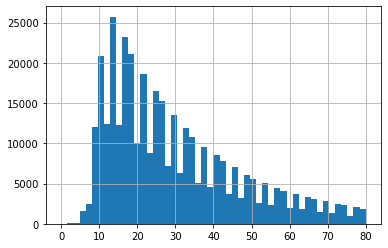

In [35]:
length_df['text'].hist(bins = 50 , range = [0,80])
plt.show()

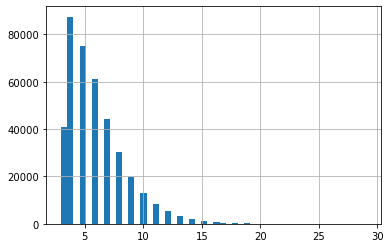

In [36]:
length_df['summary'].hist(bins = 50 )
plt.show()

In [37]:
[np.mean(text_word_count) , np.mean(summary_word_count)]

[37.703442330286705, 5.960546459760644]

In [38]:
[np.median(text_word_count) , np.median(summary_word_count) ]

[27.0, 5.0]

In [39]:
[np.std(text_word_count) , np.std(summary_word_count) ]

[36.115324196196745, 2.453859794291132]

In [40]:
[np.max(text_word_count) , np.max(summary_word_count) ]

[1892, 29]

In [41]:
max_len_text=80 
max_len_summary=10

We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [42]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

In [43]:
[len(x_tr),len(x_val),len(y_tr),len(y_val)]

[353899, 39323, 353899, 39323]

#### Preparing the Tokenizer
A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. We'll build tokenizers for text and summary:

• Text Tokenizer

In [44]:
x_tr[0]

'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [45]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [46]:
x_tr[0]

'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [47]:
#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)


In [48]:
print(x_tr[0])

[33, 27, 2788, 10187, 1450, 2676, 13911, 32574, 449, 129, 4, 23, 2788, 27, 294, 95, 1253, 85, 1892, 1009, 9031, 24267, 57]


In [49]:
#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

In [50]:
x_tr[0]

array([   33,    27,  2788, 10187,  1450,  2676, 13911, 32574,   449,
         129,     4,    23,  2788,    27,   294,    95,  1253,    85,
        1892,  1009,  9031, 24267,    57,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0])

In [51]:
x_voc_size   =  len(x_tokenizer.word_index) +1  ###Gives x_vocab size

In [52]:
(x_tokenizer.word_index)

{'like': 1,
 'good': 2,
 'taste': 3,
 'one': 4,
 'great': 5,
 'product': 6,
 'would': 7,
 'flavor': 8,
 'coffee': 9,
 'tea': 10,
 'love': 11,
 'get': 12,
 'really': 13,
 'food': 14,
 'much': 15,
 'amazon': 16,
 'use': 17,
 'also': 18,
 'time': 19,
 'little': 20,
 'buy': 21,
 'price': 22,
 'best': 23,
 'find': 24,
 'make': 25,
 'well': 26,
 'tried': 27,
 'even': 28,
 'better': 29,
 'try': 30,
 'chocolate': 31,
 'eat': 32,
 'first': 33,
 'sugar': 34,
 'water': 35,
 'could': 36,
 'used': 37,
 'found': 38,
 'sweet': 39,
 'made': 40,
 'drink': 41,
 'bag': 42,
 'bought': 43,
 'box': 44,
 'dog': 45,
 'cup': 46,
 'free': 47,
 'way': 48,
 'store': 49,
 'think': 50,
 'cannot': 51,
 'tastes': 52,
 'two': 53,
 'order': 54,
 'since': 55,
 'mix': 56,
 'day': 57,
 'delicious': 58,
 'still': 59,
 'bit': 60,
 'nice': 61,
 'recommend': 62,
 'know': 63,
 'many': 64,
 'got': 65,
 'give': 66,
 'add': 67,
 'want': 68,
 'hot': 69,
 'never': 70,
 'milk': 71,
 'stuff': 72,
 'something': 73,
 'favorite': 74,
 '

• Summary Tokenizer

In [53]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

#### Model building
Defining some important terms:

Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only
Initial State: This is used to initialize the internal states of the LSTM for the first timestep

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

In [54]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [56]:
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
#Attention layer 
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 



In [57]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      57339000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [58]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Early Stopping used to stop training the neural network at the right time by monitoring a user-specified metric. Here, we are monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases

In [60]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)  ##Mode = min means model will stop training when the quantity monitored starts to increase

In [ ]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 353899 samples, validate on 39323 samples
Epoch 1/50


In [61]:
y_tr[:,:-1]

array([[   1,  184,    2, ...,    0,    0,    0],
       [   1, 3817, 5623, ...,    0,    0,    0],
       [   1, 4885, 4667, ...,    0,    0,    0],
       ...,
       [   1,    9,   70, ...,    0,    0,    0],
       [  10,  506,   73, ..., 7077,   39,  269],
       [   1,  153, 2242, ...,    0,    0,    0]])

In [63]:
y_tr.shape

(353899, 10)